In [1]:
import asyncio 
import matplotlib

import numpy as np
import pandas as pd

from matplotlib import pylab as plt
from astropy.time import Time, TimeDelta

from lsst_efd_client import EfdClient, resample

%matplotlib inline

In [2]:
efd_client = EfdClient('summit_efd')

Query for all the `endReadout` events on the timespan of the night.

In [3]:
t1 = Time("2020-01-24T02:26:00", format='isot', scale='tai')
t2 = Time("2020-01-24T07:47:00", format='isot', scale='tai')

In [4]:
end_readout = await efd_client.select_time_series("lsst.sal.GenericCamera.logevent_endReadout", 
                                           ["imageName", "exposureTime"], t1, t2)

Now match each entry. For each `i` item with `intra` in the name, there must be an `i+1` with `extra` otherwise it is not a pair. 

In [8]:
intra_images = []
extra_images = []
intra_times = []
extra_times = []
intra_exptimes = []
extra_exptimes = []

i = 0
npairs = 0
nmiss = 0

while i < len(end_readout):
    intra = end_readout['imageName'][i]
    extra = end_readout['imageName'][i+1]
    
    if 'intra' in intra and 'extra' in extra:
#         print(f"Got a pair: {intra} x {extra}")
        intra_images.append(intra)
        extra_images.append(extra)
        intra_times.append(end_readout.index[i])
        extra_times.append(end_readout.index[i+1])
        intra_exptimes.append(end_readout['exposureTime'][i])
        extra_exptimes.append(end_readout['exposureTime'][i+1])
        i+=2
        npairs+=1
    else:
#         print(f"No Match: {intra} x {extra}")
        nmiss+=1
        i+=1

print(f"Got {npairs} pairs and {nmiss} misses.")

Got 60 pairs and 3 misses.


In [16]:
match_data = np.zeros(npairs, dtype=[('intra', '<U35'), 
                                     ('extra', '<U35'), 
                                     ('az', float), 
                                           ('el', float), 
                                           ('rot_pos', float),
                                           ('x', float), 
                                           ('y', float), 
                                           ('z', float), 
                                           ('u', float), 
                                           ('v', float), 
                                           ('w', float), 
                                     ('m1_pressure', float)])

In [34]:
for i in range(npairs):

    
    t1 = Time(intra_times[i], scale='tai') - TimeDelta(intra_exptimes[i], format='sec', scale='tai') - TimeDelta(30., format='sec', scale='tai')
    t2 = Time(extra_times[i], scale='tai') - TimeDelta(1., format='sec', scale='tai')

    azel = await efd_client.select_time_series("lsst.sal.ATMCS.mount_AzEl_Encoders", 
                                               ["elevationCalculatedAngle99", "azimuthCalculatedAngle99"], t1, t2)
    rotator = await efd_client.select_time_series("lsst.sal.ATMCS.mount_Nasmyth_Encoders",
                                                  ["nasmyth1CalculatedAngle99"], t1, t2)
    hexapod = await efd_client.select_time_series("lsst.sal.ATHexapod.command_moveToPosition",
                                                  ["x", "y", "z", "u", "v", "w"], t1, t2)
    m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                                  ["pressure"], t1, t2)
    
    if len(hexapod) < 2:
        print(f"Could not get hexapod position for pair {i+1}: {intra_images[i]} x {extra_images[i]}")
        continue
    elif '1579755351' in intra_images[i]:
        print(f"{intra_times[i]}:{intra_images[i]}")
        print(hexapod)
        print(f"{extra_times[i]}:{extra_images[i]}")

    rot_pos = np.mean(rotator['nasmyth1CalculatedAngle99'])
    el = np.mean(azel['elevationCalculatedAngle99'])
    az = np.mean(azel['azimuthCalculatedAngle99'])
    x = (hexapod['x'][len(hexapod)-2]+hexapod['x'][len(hexapod)-1])/2.
    y = (hexapod['y'][len(hexapod)-2]+hexapod['y'][len(hexapod)-1])/2.
    z = (hexapod['z'][len(hexapod)-2]+hexapod['z'][len(hexapod)-1])/2.
    u = (hexapod['u'][len(hexapod)-2]+hexapod['u'][len(hexapod)-1])/2.
    v = (hexapod['v'][len(hexapod)-2]+hexapod['v'][len(hexapod)-1])/2.
    w = (hexapod['w'][len(hexapod)-2]+hexapod['w'][len(hexapod)-1])/2.
    m1 = np.mean(m1_pressure['pressure'])
    match_data[i] = (intra_images[i], extra_images[i], az, el, rot_pos, x, y, z, u, u, w, m1)
#     print(az, el, rot_pos, x, y, z, u, u, w)
print("done")

done


In [19]:
df = pd.DataFrame(match_data)

In [20]:
df

,intra,extra,az,el,rot_pos,x,y,z,u,v,w,m1_pressure
0,1579832794-HD82741_intra-0-1,1579832831-HD82741_extra-0-1,-52.112159,78.720513,-75.995403,-4.350000,0.100000,0.518000,0.35,0.35,0.0,124695.356799
1,1579833109-HD82741_intra-0-1,1579833147-HD82741_extra-0-1,-55.875799,77.825513,-73.705150,-4.350000,0.100000,0.518000,0.35,0.35,0.0,124226.828583
2,1579833201-HD82741_intra-0-1,1579833238-HD82741_extra-0-1,-56.949368,77.537264,-73.100851,-4.350000,0.100000,0.518000,0.35,0.35,0.0,124188.862631
3,1579833798-HD82741_intra-0-1,1579833836-HD82741_extra-0-1,-62.772597,75.659476,-80.040792,-4.350000,0.100000,0.418000,0.35,0.35,0.0,122930.742871
4,1579834188-HD82741_intra-0-1,1579834225-HD82741_extra-0-1,-65.860640,74.393470,-78.957261,-4.350000,0.100000,0.458000,0.35,0.35,0.0,122449.942029
5,1579836061-HD82741_intra-0-1,1579836103-HD82741_extra-0-1,-76.262467,67.987701,-73.606651,-4.350000,0.100000,0.442816,0.35,0.35,0.0,117537.065967
6,1579836171-HD82741_intra-0-1,1579836214-HD82741_extra-0-1,-76.721014,67.601731,-73.746983,-4.350000,0.100000,0.443202,0.35,0.35,0.0,116817.985946
7,1579836591-HD82741_intra-0-1,1579836634-HD82741_extra-0-1,-78.377421,66.114601,-74.397146,-4.350000,0.100000,0.459070,0.35,0.35,0.0,115688.232983
8,1579836965-HD82741_intra-0-1,1579837038-HD82741_extra-0-1,-79.828771,64.689010,-69.878409,-4.350000,0.100000,0.432069,0.35,0.35,0.0,114200.905532
9,1579837309-HD82741_intra-0-1,1579837381-HD82741_extra-0-1,-80.979315,63.466269,-67.835899,-4.350000,0.100000,0.509084,0.35,0.35,0.0,112716.512078


In [31]:
df.to_csv("20200123_match_all.csv")

In [22]:
np.savetxt("20200123_matched_data.txt", np.array(intra_images +extra_images), fmt="%s")

In [ ]:
(1.970002+0.470002)/2.

In [ ]:
(-1.029998+1.970002)/2.

In [27]:
df2 = pd.DataFrame.from_csv("20200123_match.csv")

/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


In [28]:
df2 

,extra,az,el,rot_pos,x,y,z,u,v,w,m1_pressure
intra,,,,,,,,,,,
1579848438-etaLeo_intra-0-1,1579848483-etaLeo_extra-0-1,-2.825425,43.138912,-44.498513,-5.038109,0.701626,0.535407,0.35,0.35,0.0,83327.808438
1579849059-etaLeo_intra-0-1,1579849104-etaLeo_extra-0-1,-6.245939,42.965045,-41.589065,-5.038109,0.708685,0.535844,0.35,0.35,0.0,81062.470728
1579849576-etaLeo_intra-0-1,1579849620-etaLeo_extra-0-1,-9.042814,42.728860,-39.307161,-5.038109,0.718516,0.610367,0.35,0.35,0.0,78983.211881
1579850144-etaLeo_intra-0-1,1579850175-etaLeo_extra-0-1,-12.069811,42.344559,-45.310906,-5.038109,0.735260,0.611396,0.35,0.35,0.0,82292.000269
1579850788-etaLeo_intra-0-1,1579850828-etaLeo_extra-0-1,-15.441389,41.797452,-42.833626,-5.038109,0.759522,2.011778,0.35,0.35,0.0,82929.113940
1579851935-etaLeo_intra-0-1,1579851975-etaLeo_extra-0-1,-21.280756,40.505316,-38.912698,-5.038109,0.817868,1.903681,0.35,0.35,0.0,82542.131777


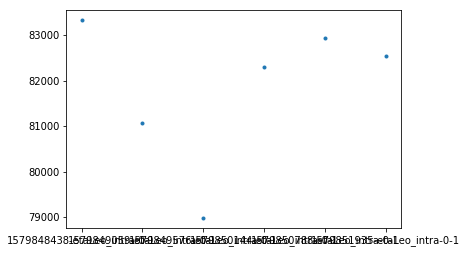

In [29]:
plt.plot(df2['m1_pressure'],'.')

In [38]:
t1 = Time("2020-01-24T06:40:10.399", format='isot', scale='tai')
t2 = Time("2020-01-24T07:46:45.959", format='isot', scale='tai')

m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                              ["pressure"], t1, t2)



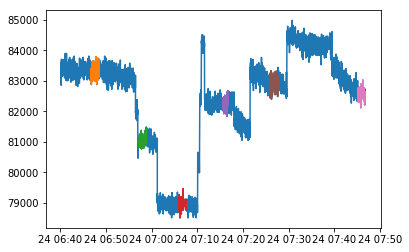

In [42]:
fig = plt.figure(1)

ax = fig.add_subplot(111)

t1 = Time("2020-01-24T06:40:10.399", format='isot', scale='tai')
t2 = Time("2020-01-24T07:46:45.959", format='isot', scale='tai')

m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                              ["pressure"], t1, t2)

ax.plot(m1_pressure)

for i in [46, 47, 49, 51, 53, 59]:
    
    t1 = Time(intra_times[i], scale='tai') - TimeDelta(intra_exptimes[i], format='sec', scale='tai') - TimeDelta(30., format='sec', scale='tai')
    t2 = Time(extra_times[i], scale='tai') - TimeDelta(1., format='sec', scale='tai')

    m1_pressure = await efd_client.select_time_series("lsst.sal.ATPneumatics.m1AirPressure",
                                              ["pressure"], t1, t2)

    ax.plot(m1_pressure)
